<a href="https://colab.research.google.com/github/jtcarrion/PolypNet/blob/main/PolypNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import pandas as pd
from google.colab import drive
import io
from IPython.display import Image, display
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import random

In [17]:
# Mount drive in order to get CSV file from Drive folder
drive.mount("/content/drive/", force_remount=True)

img_dir = "/content/drive/Shareddrives/BMI_540/BMI_540_Project/Original"
mask_dir = "/content/drive/Shareddrives/BMI_540/BMI_540_Project/GT"
img_size = (384, 288, 3)
num_classes = 1
batch_size = 16


img_paths = sorted(
    [
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
        if fname.endswith(".tif")
    ]
)

gt_paths = sorted(
    [
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith(".tif")
    ]
)

input_img = sorted(
    [
        fname
        for fname in os.listdir(img_dir)
        if fname.endswith(".tif")
    ]
)

input_mask = sorted(
    [
        fname
        for fname in os.listdir(mask_dir)
        if fname.endswith(".tif")
    ]
)

Mounted at /content/drive/


In [39]:
print(img_paths[502])
print(gt_paths[502])

print(input_img[502])
print(input_mask[502])


/content/drive/Shareddrives/BMI_540/BMI_540_Project/Original/551.tif
/content/drive/Shareddrives/BMI_540/BMI_540_Project/GT/551.tif
551.tif
551.tif


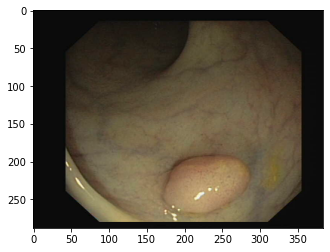

In [24]:
from osgeo import gdal
import matplotlib.pyplot as plt  
  
dataset = gdal.Open(img_paths[39])

band1 = dataset.GetRasterBand(1) # Red channel
band2 = dataset.GetRasterBand(2) # Green channel
band3 = dataset.GetRasterBand(3) # Blue channel


b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()

img = np.dstack((b1, b2, b3))
f = plt.figure()
plt.imshow(img)
plt.show()

In [4]:
"""function to build Unet network to copy paste (keras & tensorflow 2.X)."""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, MaxPooling2D, Conv2D, concatenate, Conv2DTranspose


def build_encoder_block(previous_layer, filters, activation, use_batchnorm, dropout):
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(previous_layer)
    if use_batchnorm:
        c = BatchNormalization()(c)
    if dropout:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(c)
    if use_batchnorm:
        c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2))(c)

    return c, p


def build_decoder_block(previous_layer, skip_layer, is_last, filters, activation, use_batchnorm, dropout):
    u = Conv2DTranspose(filters, (2, 2), strides=(2, 2),
                        padding='same')(previous_layer)
    u = concatenate([u, skip_layer])
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(u)
    if use_batchnorm:
        c = BatchNormalization()(c)
    if dropout:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(c)
    if use_batchnorm and not is_last:
        c = BatchNormalization()(c)

    return c


def build_bottleneck(previous_layer, filters, activation, use_batchnorm, dropout):
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(previous_layer)
    if use_batchnorm:
        c = BatchNormalization()(c)
    if dropout:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, (3, 3), activation=activation,
               kernel_initializer='he_normal', padding='same')(c)
    if use_batchnorm:
        c = BatchNormalization()(c)

    return c


def build_Unet(
    input_shape,
    output_channels,
    base_filters  = 32,
    depth         = 4,
    dropout       = 0.4,
    activation    = 'relu',
    use_batchnorm = True,
):
    """
    From the given parameters, builds a modified Unet type architecture.
    Parameters:
        input_shape (tuple):
            Shape of the input images (channel last), e.g (128, 128, 3)
        output_channels (int):
            Number of ouputs (1 if binary segmentation)
        base_filters (int):
            Number of filter for the layer 0, the number of filters increase
            exponentially such nb_filters = base_filter * 2 ** (layer_depth)
        depth (int):
            Number of layer in the encoding / decoding part
        dropout (float, bool):
            If not False, dropout rate to be applied
        activation (string):
            Activation function to use beetwen each layers
        use_batchnorm (bool):
            If True, apply batch normalization after each conv layer
    Returns:
        model (keras.model)
    """
    encoder_blocks = []
    decoder_blocks = []

    input_layer = Input(input_shape)

    # encoder
    for encoding_index in range(depth):
        previous_layer = input_layer if encoding_index == 0\
            else encoder_blocks[-1][1]

        encoder_block = build_encoder_block(
            previous_layer,
            base_filters * 2 ** encoding_index,
            activation,
            use_batchnorm,
            dropout
        )

        encoder_blocks.append(encoder_block)

    # bottleneck
    bottleneck = build_bottleneck(
        encoder_blocks[-1][1],
        base_filters * 2 ** depth,
        activation,
        use_batchnorm,
        dropout
    )

    # decoder
    for decoding_index in range(depth):
        previous_layer = bottleneck if decoding_index == 0\
            else decoder_blocks[-1]
        skip_layer = encoder_blocks[- decoding_index - 1][0]

        decoder_block = build_decoder_block(
            previous_layer,
            skip_layer,
            decoding_index == depth - 1,
            base_filters * 2 ** (depth - 1 - decoding_index),
            activation,
            use_batchnorm,
            dropout
        )

        decoder_blocks.append(decoder_block)

    output_function = 'softmax' if output_channels > 1 else 'sigmoid'
    ouput_layer     = Conv2D(output_channels, (1, 1),
                             activation=output_function)(decoder_blocks[-1])

    model = Model(inputs=[input_layer], outputs=[ouput_layer])

    return model

In [7]:
model = build_Unet(img_size,
    num_classes,
    base_filters  = 32,
    depth         = 4,
    dropout       = 0.4,
    activation    = 'relu',
    use_batchnorm = True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 288, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 288, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [6]:
!pip install segmentation_models
import segmentation_models as sm

import keras
# or from tensorflow import keras

keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

model2 = sm.Unet('resnet34', input_shape=img_size, classes=1, activation='sigmoid')

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.1 MB/s 
Segmentation Models: using `keras` framework.
85521592/85521592 [==============================] - 1s 0us/step


In [36]:
random.seed(0)
train_size = int(len(img_paths)*0.85)
print(train_size)
print(len(img_paths))


temp = list(zip(input_img, input_mask))
z = random.sample(temp, train_size)
X_train, y_train = zip(*z)

X_test = list(set(input_img).difference(X_train))
y_test = list(set(input_mask).difference(y_train))

X_test.sort()
y_test.sort()

print(len(X_train))
print(len(y_train))
print((X_train[100]))
print((y_train[100]))

print('-----------')
print(len(X_test))
print(len(y_test))
print((X_test[39]))
print((y_test[39 ]))


520
612
520
520
349.tif
349.tif
-----------
92
92
37.tif
37.tif


In [37]:
# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

model2.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

model2.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=50,
   validation_data=(X_test, y_test),
)

Epoch 1/50


ValueError: ignored